# Module

In [18]:
from scipy import sparse
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler

# Data

In [2]:
data_path = "./data/"

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [3]:
train.shape, test.shape, submission.shape

((300000, 24), (200000, 23), (200000, 1))

In [4]:
all_data = pd.concat([train, test], axis=0)
all_data.shape

(500000, 24)

In [5]:
all_data.drop('target', axis=1, inplace=True)
all_data.shape

(500000, 23)

In [6]:
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8


# Feature Engineering

## Binary Features

In [7]:
all_data['bin_3'] = all_data['bin_3'].map({"F": 0, "T": 1})
all_data['bin_4'] = all_data['bin_4'].map({"N": 0, "Y": 1})

print(all_data['bin_3'].value_counts())
print(all_data['bin_4'].value_counts())

bin_3
1    255913
0    244087
Name: count, dtype: int64
bin_4
1    319640
0    180360
Name: count, dtype: int64


## Ordinal Features

In [8]:
ord1dict = {'Novice':0, 'Contributor':1,
'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2,
'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

print(all_data['ord_1'].value_counts())
print(all_data['ord_2'].value_counts())

ord_1
0    210877
4    129143
1     71516
3     46755
2     41709
Name: count, dtype: int64
ord_2
0    166065
5    106649
4    101263
1     56434
3     36744
2     32845
Name: count, dtype: int64


In [10]:
ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder()
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(f"{feature}: {categories}")

ord_3: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5: ['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX

In [11]:
all_data[ord_345].head()

,ord_3,ord_4,ord_5
id,,,
0,7.0,3.0,136.0
1,0.0,0.0,93.0
2,7.0,17.0,31.0
3,8.0,3.0,134.0
4,0.0,17.0,158.0


## Nominal Features

In [12]:
nom_features = ['nom_' + str(i) for i in range(10)]
nom_features

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9']

In [13]:
one_hot_encoder = OneHotEncoder()
nom_encoded = one_hot_encoder.fit_transform(all_data[nom_features])
nom_encoded

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

- nom_5 ~ nom_9는 고유값이 최대 12,000개에 달하는 고차원 명목형 변수로, 일반적으로 이러한 변수에 원-핫 인코딩을 적용하면 차원의 저주로 인한 성능 저하를 유발할 수 있음 
- 하지만 본 분석에서는 훈련 데이터가 30만 개로 충분히 크기 때문에, 늘어난 차원에도 불구하고 모델이 과적합될 위험이 적다고 판단하였음

In [14]:
all_data = all_data.drop(nom_features, axis=1)

## Date Features

In [15]:
date_features = ['day', 'month']

date_encoded = one_hot_encoder.fit_transform(all_data[date_features])
all_data = all_data.drop(date_features, axis=1)

date_encoded

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

## Scaling

- 순서형 피쳐는 여타 피쳐들과 달리 인코딩된 값의 범위가 0~1을 벗어나기에, 피쳐 값의 범위를 0~1로 조정함

In [17]:
ord_features = ['ord_' + str(i) for i in range(6)]

all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,,,,,,
0,0,0,0,1,1,0.5,1.0,0.2,0.500000,0.12,0.712042
1,0,1,0,1,1,0.0,1.0,0.6,0.000000,0.00,0.486911
2,0,0,0,0,1,0.0,0.5,1.0,0.500000,0.68,0.162304
3,0,1,0,0,1,0.0,1.0,0.8,0.571429,0.12,0.701571
4,0,0,0,0,0,0.0,1.0,0.0,0.000000,0.68,0.827225


## Gathering

In [19]:
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data), nom_encoded, date_encoded], format='csr')
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

## Split

In [20]:
num_train = len(train)
x_train = all_data_sprs[:num_train]
x_test = all_data_sprs[num_train:]

y = train['target']

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.1, 
                                                  stratify=y, random_state=2025)

# Model

In [22]:
%%time

def objective_logistic(trial: optuna.trial.Trial):
    params = {
        'C':trial.suggest_float('C', 1e-3, 1e-1, log=True),
        'max_iter':trial.suggest_int('max_iter', 500, 1200, step=100),
        'solver':'liblinear'
    }

    model = LogisticRegression(**params, random_state=2025)
    model.fit(x_train, y_train)
    
    y_val_preds = model.predict_proba(x_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_preds)
    
    return roc_auc

sampler = TPESampler(seed=2025)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_logistic, n_trials=30)

print(f'Total Trials : {len(study.trials)}')
print(f'Best Trial : {study.best_trial.number}')
print(f'Best ROC AUC of Logistic : {study.best_value:.4f}')
print('Best Parameters of Logistic')
for key, value in study.best_params.items():
    print(f'{key} : {value}')

[I 2025-11-17 08:30:13,724] A new study created in memory with name: no-name-1f7d4a82-a795-4821-9574-b6b385da9988
[I 2025-11-17 08:30:15,422] Trial 0 finished with value: 0.78100641223275 and parameters: {'C': 0.001866277960465418, 'max_iter': 1200}. Best is trial 0 with value: 0.78100641223275.
[I 2025-11-17 08:30:23,423] Trial 1 finished with value: 0.8047434579375081 and parameters: {'C': 0.07331811314274288, 'max_iter': 800}. Best is trial 1 with value: 0.8047434579375081.
[I 2025-11-17 08:30:25,950] Trial 2 finished with value: 0.7906096159501427 and parameters: {'C': 0.005976832600099019, 'max_iter': 700}. Best is trial 1 with value: 0.8047434579375081.
[I 2025-11-17 08:30:30,761] Trial 3 finished with value: 0.7998654173006734 and parameters: {'C': 0.020641210885923914, 'max_iter': 800}. Best is trial 1 with value: 0.8047434579375081.
[I 2025-11-17 08:30:39,215] Trial 4 finished with value: 0.8049263908068653 and parameters: {'C': 0.0848158147848906, 'max_iter': 1100}. Best is t

Total Trials : 30
Best Trial : 22
Best ROC AUC of Logistic : 0.8050
Best Parameters of Logistic
C : 0.09892653223260224
max_iter : 1000
CPU times: user 3min 6s, sys: 5min 40s, total: 8min 47s
Wall time: 2min 23s


- 02_Baseline 모델의 성능(0.7978)보다 개선되었음

# Submission

In [23]:
study.best_params

{'C': 0.09892653223260224, 'max_iter': 1000}

In [25]:
num_train = len(train)
x_train = all_data_sprs[:num_train]
x_test = all_data_sprs[num_train:]

y = train['target']

In [29]:
model = LogisticRegression(**study.best_params, solver='liblinear', random_state=2025)
model.fit(x_train, y)

LogisticRegression(C=0.09892653223260224, max_iter=1000, random_state=2025,
                   solver='liblinear')

In [30]:
y_test_preds = model.predict_proba(x_test)[:, 1]
submission['target'] = y_test_preds

In [31]:
submission.head()

,target
id,
300000,0.341831
300001,0.695675
300002,0.126431
300003,0.437734
300004,0.863960


In [35]:
submission.to_csv(data_path + "submission01.csv")

In [36]:
submission.head()

,target
id,
300000,0.341831
300001,0.695675
300002,0.126431
300003,0.437734
300004,0.863960


In [37]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c cat-in-the-dat -f "./data/submission01.csv" -m "03_Emprovments_2"

100%|██████████████████████████████████████| 5.06M/5.06M [00:00<00:00, 10.8MB/s]
Successfully submitted to Categorical Feature Encoding Challenge

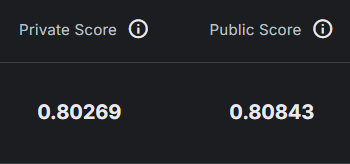
- 20/1341
- 1등 private Score : 0.80283